## Data Challenge 3 Description

We have data about users who hit our site: whether they converted or not as well as some of
their characteristics such as their country, the marketing channel, their age, whether they are
repeat users and the number of pages visited during that session (as a proxy for site
activity/time spent on site).
Your project is to:
Predict conversion rate
Come up with recommendations for the product team and the marketing team to
improve conversion rate

In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import dateutil
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
df1 = pd.read_csv('conversion_data.csv')
df1.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


## Step1: Explore the data

In [9]:
print 'total record entries', len(df1)
print ''
print 'unique countries counts'
print df1['country'].value_counts()
print ''
print 'new_user counts'
print df1['new_user'].value_counts()
print ''
print 'unique sources counts'
print df1['source'].value_counts()
print ''
print 'converted counts'
print df1['converted'].value_counts()
# the conversion rate is about 3.2%

total record entries 316200

unique countries counts
US         178092
China       76602
UK          48450
Germany     13056
Name: country, dtype: int64

new_user counts
1    216744
0     99456
Name: new_user, dtype: int64

unique sources counts
Seo       155040
Ads        88740
Direct     72420
Name: source, dtype: int64

converted counts
0    306000
1     10200
Name: converted, dtype: int64


In [43]:
# fake self-report age found, 1 claimed to be 111, and 1 claimed to be 123
# other users are between 17 - 79
df1[['age', 'total_pages_visited']].describe()

,age,total_pages_visited
count,316200.000000,316200.000000
mean,30.569858,4.872966
std,8.271802,3.341104
min,17.000000,1.000000
25%,24.000000,2.000000
50%,30.000000,4.000000
75%,36.000000,7.000000
max,123.000000,29.000000


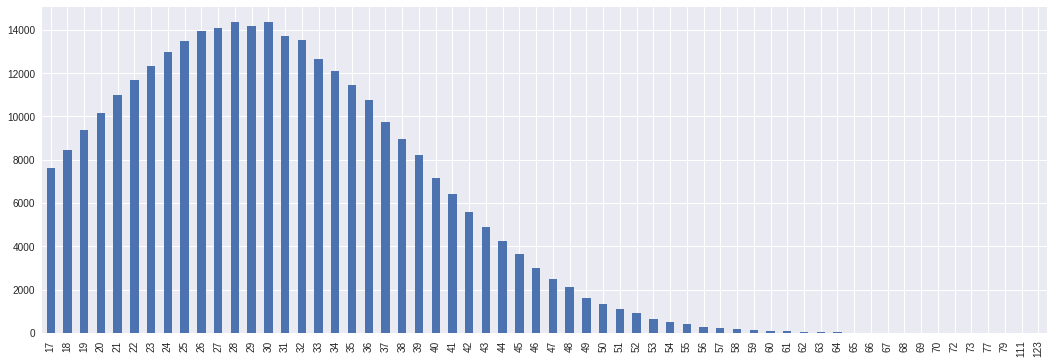

In [44]:
age_prob = df1['age'].value_counts().sort_index()
#age_prob = df1['age'].value_counts(normalize=True).sort_index()
age_prob.plot(kind='bar',figsize=(18, 6))
# the main user age group is around 27-30

In [10]:
# there is no missing data
df1.isnull().any().any()  

False

## Step 2: data processing

In [68]:
df2=pd.get_dummies(columns=['country', 'new_user', 'source'], data=df1)
df2.head()

,age,total_pages_visited,converted,country_China,country_Germany,country_UK,country_US,new_user_0,new_user_1,source_Ads,source_Direct,source_Seo
0,25,1,0,0,0,1,0,0,1,1,0,0
1,23,5,0,0,0,0,1,0,1,0,0,1
2,28,4,0,0,0,0,1,0,1,0,0,1
3,39,5,0,1,0,0,0,0,1,0,0,1
4,30,6,0,0,0,0,1,0,1,0,0,1


In [79]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

y = df2['converted']
X = df2.loc[:, df2.columns != 'converted']
# with the same random state parameter, the data set will be split in the same way
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=5)
df_train = pd.concat([X_train, y_train], axis=1)

Since the conversion rate is only 3.2%, this is a imbalanced data set. I need to perform up-sampling for the training data set. 

In [80]:
# under-sampling and oversampling 
from sklearn.utils import resample


df_train_majority = df_train[df_train.converted==0]
df_train_minority = df_train[df_train.converted==1]

nsamples = int(len(df_train_majority))

# Upsample minority class
df_train_minority_upsampled = resample(df_train_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=nsamples,    # to match majority class
                                 random_state=123) # reproducible results




# Combine majority class with upsampled minority class
df_train_upsampled = pd.concat([df_train_majority, df_train_minority_upsampled])

print df_train_upsampled.converted.value_counts()

y_train = df_train_upsampled['converted']
X_train = df_train_upsampled.loc[:, df_train_upsampled.columns != 'converted']

1    214142
0    214142
Name: converted, dtype: int64


## Step 3: machine learning

In [93]:
from sklearn import tree
DT = tree.DecisionTreeClassifier()
DT = DT.fit(X_train, y_train)
y_pred_DT = DT.predict(X_test)

In [94]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred_DT))

             precision    recall  f1-score   support

          0       0.99      0.95      0.97     91858
          1       0.34      0.84      0.48      3002

avg / total       0.97      0.94      0.95     94860



In [97]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier()
RF.fit(X_train, y_train)
y_pred_RF = RF.predict(X_test)
print(metrics.classification_report(y_test, y_pred_RF))

             precision    recall  f1-score   support

          0       0.99      0.95      0.97     91858
          1       0.34      0.85      0.49      3002

avg / total       0.97      0.94      0.95     94860



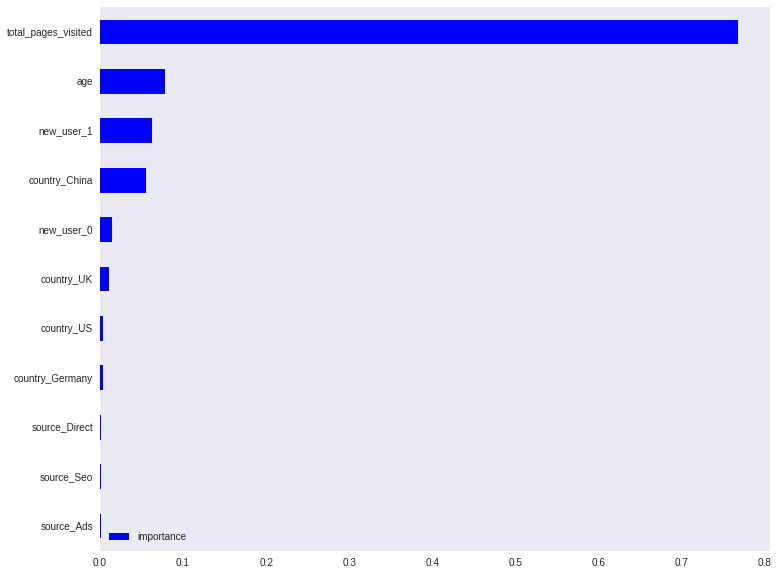

In [89]:
# predict feature importance from random forest classifier
names = X_train.columns
ratios = RF.feature_importances_

feature_important = pd.DataFrame(index=names, data=ratios, columns=['importance'])
feature_important = feature_important.sort_values(by=['importance'], ascending=True)
feature_important.plot(kind='barh', stacked=True, color=['blue'], grid=False, figsize=(12, 10))

Findings:
1. the more pages visited, the more likedly the user will convert
2. putting effort developing new-users will likely improve the revenue
3. customers from China should be more targeted. 